<a href="https://colab.research.google.com/github/zooodung/Face_Image_Emotion_Classification/blob/JS/FP_MODELING_ViT_b16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import zipfile
import os

def unzip_file(zip_file_path, extract_dir):
    # 압축 파일 열기
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # 압축 해제
        zip_ref.extractall(extract_dir)

# 압축 파일 경로와 추출할 디렉토리 경로 지정
zip_file_path = '/content/drive/MyDrive/Project/Data/img_preprocessed.zip'
extract_dir = '/content/img_p'

# 압축 파일 풀기
unzip_file(zip_file_path, extract_dir)

### ViT_b16

### Import

In [ ]:
!pip install vit_keras
!pip install tensorflow-addons
! pip install face_recognition
! pip install imgaug
! pip install dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=eb0709557c8ea34815be83a459805a3b74c29ae86f54e47a5d6c47ff6bd2c654
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import os
import numpy as np
import tensorflow as tf
from vit_keras import vit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa
import face_recognition
import imgaug as ia

### 데이터 증강

In [ ]:
#faceposeaugument는 pytorch 기반이라 tensorflow와 호환되는 imgaug 라이브러리 사용
def augment_face_pose(image, augmenter):
    # RGB 이미지로 변환
    image_rgb = image.astype('uint8')[:, :, ::-1]

    # 특징점 추출
    landmarks = face_recognition.face_landmarks(image_rgb)
    if not landmarks:  # 얼굴이 검출되지 않으면 증강 X
        return image

    # 랜드마크 좌표 추출
    keypoints = [ia.Keypoint(x=landmark[0], y=landmark[1]) for landmark in landmarks[0]['chin']]

    # 랜드마크 기반 증강
    augmented_image, _ = augmenter(image=image, keypoints=ia.KeypointsOnImage(keypoints, shape=image.shape))
    return augmented_image

In [ ]:
# 랜드마크 기반 Affine 변환 설정
augmenter = iaa.Affine(
    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # 얼굴 크기 조절 (80% ~ 120%)
    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # 얼굴 위치 이동 (-20% ~ 20%)
    rotate=(-25, 25),  # 얼굴 회전 (-25도 ~ 25도)
    shear=(-10, 10),  # 얼굴 왜곡 (-10도 ~ 10도)
)

### 데이터 로드

In [ ]:
# 데이터 디렉토리 설정 (본인 환경에 맞게 수정)
train_data_dir = '/content/img_p/train'
val_data_dir = '/content/img_p/val'

# 이미지 크기 및 배치 크기 설정
image_size = 224
batch_size = 32

# 데이터 증강 및 전처리 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    preprocessing_function=lambda img: augment_face_pose(img, augmenter),  # 증강 함수 imgaug적용
)

val_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4324 images belonging to 4 classes.
Found 765 images belonging to 4 classes.


### 모델 로드

In [ ]:
base_model = vit.vit_b16(
    image_size=image_size,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Reshape((1, 1, -1))(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4개 클래스 anger/happy/sadness/panic
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience = 7,
    restore_best_weights=True
    )

### 모델 학습

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 50
history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = val_generator,
    callbacks = [early_stopping]
)

Epoch 1/50
136/136 [==============================] - 246s 2s/step - loss: 0.0863 - accuracy: 0.9695 - val_loss: 0.4018 - val_accuracy: 0.9046
Epoch 2/50
136/136 [==============================] - 208s 2s/step - loss: 0.0843 - accuracy: 0.9713 - val_loss: 0.4680 - val_accuracy: 0.9033
Epoch 3/50
136/136 [==============================] - 209s 2s/step - loss: 0.0803 - accuracy: 0.9713 - val_loss: 0.3541 - val_accuracy: 0.9085
Epoch 4/50
136/136 [==============================] - 230s 2s/step - loss: 0.1571 - accuracy: 0.9422 - val_loss: 0.3850 - val_accuracy: 0.8967
Epoch 5/50
136/136 [==============================] - 209s 2s/step - loss: 0.0605 - accuracy: 0.9766 - val_loss: 0.3233 - val_accuracy: 0.9137
Epoch 6/50
136/136 [==============================] - 209s 2s/step - loss: 0.0587 - accuracy: 0.9801 - val_loss: 0.4571 - val_accuracy: 0.8915
Epoch 7/50
136/136 [==============================] - 220s 2s/step - loss: 0.0862 - accuracy: 0.9695 - val_loss: 0.3872 - val_accuracy: 0.9046

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(val_generator)

24/24 [==============================] - 3s 112ms/step - loss: 0.3233 - accuracy: 0.9137


### Loss, Accuray 시각화

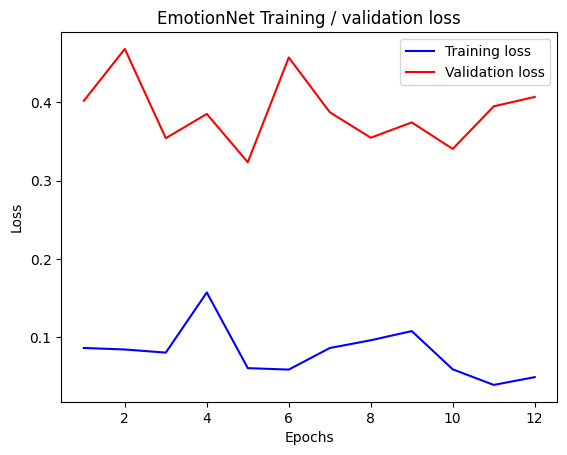

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('EmotionNet Training / validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

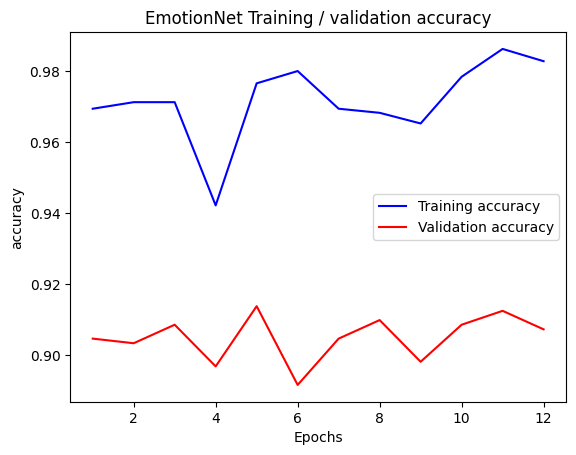

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('EmotionNet Training / validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Model Export

In [ ]:
model.save('/content/drive/MyDrive/Project/ViT_b16')

## Test Data에 대한 성능

In [ ]:
import zipfile
import os

def unzip_file(zip_file_path, extract_dir):
    # 압축 파일 열기
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # 압축 해제
        zip_ref.extractall(extract_dir)

# 압축 파일 경로와 추출할 디렉토리 경로 지정
zip_file_path = '/content/drive/MyDrive/Project/Data/Test_data/img_p/test_img_p.zip'
extract_dir = '/content/test_img_p'

# 압축 파일 풀기
unzip_file(zip_file_path, extract_dir)

In [ ]:
test_data_dir = '/content/test_img_p'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(image_size, image_size),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=False
)

Found 1116 images belonging to 4 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(val_generator)

24/24 [==============================] - 3s 111ms/step - loss: 0.3233 - accuracy: 0.9137


#### 성능 Report

In [ ]:
test_predictions = model.predict(test_generator)
test_predictions = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

print(classification_report(test_true_labels, test_predictions, target_names=list(train_generator.class_indices.keys())))

35/35 [==============================] - 4s 110ms/step
              precision    recall  f1-score   support

       anger       0.76      0.74      0.75       276
       happy       0.85      0.98      0.91       290
       panic       0.89      0.75      0.82       270
     sadness       0.79      0.81      0.80       280

    accuracy                           0.82      1116
   macro avg       0.82      0.82      0.82      1116
weighted avg       0.82      0.82      0.82      1116



#### 개별 이미지 감정 분류

In [ ]:
def predict_emotion(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(image_size, image_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    class_labels = list(train_generator.class_indices.keys())
    return class_labels[predicted_class[0]]

example_image_path = '/content/test_img_p/anger/4h2c9e3ad14d2f5f2a48c99856e24e03882a82453748a3dd54d6b4c833d2aarpk.jpg'
predicted_emotion = predict_emotion(example_image_path)
print(f'The predicted emotion for the image is: {predicted_emotion}')

1/1 [==============================] - 0s 48ms/step
The predicted emotion for the image is: anger
